In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


TODO:
- Selecting the 1972-2018 period for quantile bias correction isn't great (the obs sample is too small for calculating robust quantiles), so we need to use all the data. This probably means we need to de-trend the data first.

In [2]:
mildura_lat = -34.2
mildura_lon = 142.1

### Observations

In [3]:
#txx_obs_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'
txx_obs_file = '/Users/irv033/Desktop/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'

In [4]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [5]:
da_obs = ds_obs['tasmax'].sel({'lat': mildura_lat, 'lon': mildura_lon}, method='nearest')

In [6]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [7]:
df_obs = da_obs.to_dataframe()

In [8]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
1990-06-30 00:00:00 -34.0  142.0  1990-01-03  48.070168
1939-06-30 00:00:00 -34.0  142.0  1939-01-10  47.354195
2001-06-30 00:00:00 -34.0  142.0  2001-01-14  47.192989
2020-06-30 00:00:00 -34.0  142.0  2019-12-20  46.924156
2019-06-30 00:00:00 -34.0  142.0  2019-01-04  46.915867
1979-06-30 00:00:00 -34.0  142.0  1979-01-14  46.859818
2017-06-30 00:00:00 -34.0  142.0  2017-02-10  46.850529
2009-06-30 00:00:00 -34.0  142.0  2009-02-07  46.835129
1932-06-30 00:00:00 -34.0  142.0  1932-01-27  46.403103
1982-06-30 00:00:00 -34.0  142.0  1982-01-24  46.376907


In [9]:
linear_fit_obs = np.polyfit(da_obs.time.dt.year.values, da_obs.values, 1)
linear_data_obs = np.polyval(linear_fit_obs, da_obs.time.dt.year.values)

In [10]:
base_mean_obs = da_obs.sel(time=slice('1972-01-01', '2018-12-31')).mean().values

In [14]:
da_obs_detrended = (da_obs - linear_data_obs) + base_mean_obs
da_obs_detrended.attrs = da_obs.attrs

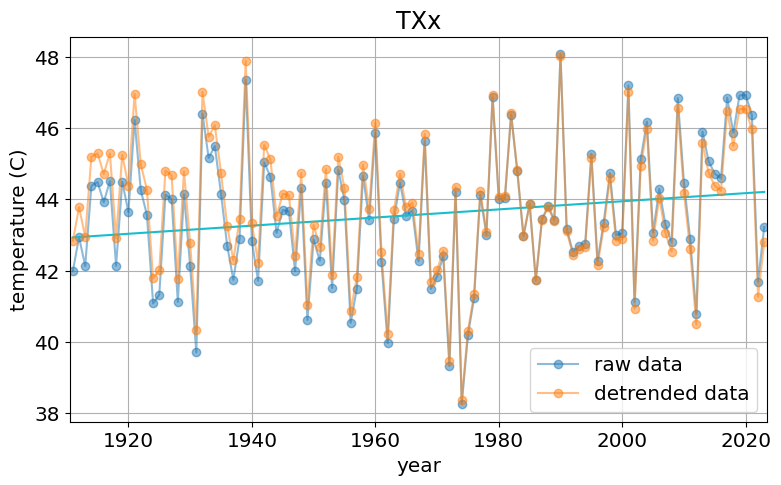

In [16]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_obs['time'].dt.year.values
plt.plot(years, da_obs.values, marker='o', label='raw data', color='tab:blue', alpha=0.5)
plt.plot(years, linear_data_obs, color='tab:cyan')
plt.plot(years, da_obs_detrended.values, marker='o', label='detrended data', color='tab:orange', alpha=0.5)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.legend()
plt.grid()

In [17]:
gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended = eva.fit_gev(da_obs_detrended.values)
print(f'Shape parameter: {gev_shape_obs_detrended:.2f}')
print(f'Location parameter: {gev_loc_obs_detrended:.2f}')
print(f'Scale parameter: {gev_scale_obs_detrended:.2f}')

Shape parameter: 0.32
Location parameter: 43.17
Scale parameter: 1.88


### Model data

In [18]:
#txx_model_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'
txx_model_file = '/Users/irv033/Desktop/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'

In [19]:
ds_model = fileio.open_dataset(txx_model_file)

In [20]:
da_model = ds_model['tasmax'].sel({'lat': mildura_lat, 'lon': mildura_lon}, method='nearest')

In [21]:
da_model = da_model.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [22]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
linear_fit_model = np.polyfit(da_model_stacked.time.dt.year.values, da_model_stacked.values, 1)
linear_data_model = np.polyval(linear_fit_model, np.unique(da_model_stacked.time.dt.year.values))

In [24]:
da_model_stacked_base = time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])
base_mean_model = da_model_stacked_base.mean().values

In [25]:
value_year_pairs = np.column_stack((da_model_stacked.values, da_model_stacked.time.dt.year.values))
detrended_data = []
for value, year in value_year_pairs:
    af = np.polyval(linear_fit_model, year)
    detrended_value = value - af + base_mean_model
    detrended_data.append(detrended_value)
detrended_data = np.array(detrended_data)

In [26]:
da_model_detrended_stacked = da_model_stacked * 0 + detrended_data
da_model_detrended_stacked.attrs = da_model_stacked.attrs

In [27]:
da_model_detrended = da_model_detrended_stacked.unstack()

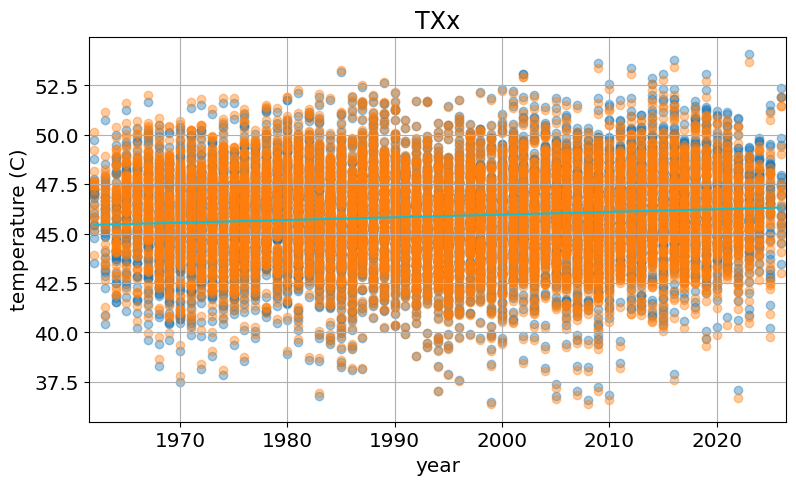

In [43]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_model_stacked['time'].dt.year.values
unique_years = np.unique(da_model_stacked.time.dt.year.values)
plt.scatter(years, da_model_stacked.values, marker='o', color='tab:blue', alpha=0.4, label='raw data')
plt.plot(unique_years, linear_data_model, color='tab:cyan')
plt.scatter(years, da_model_detrended_stacked.values, marker='o', color='tab:orange', alpha=0.4, label='detrended data')
plt.xlim(unique_years[0] - 0.5, unique_years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
#plt.legend()
plt.grid()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


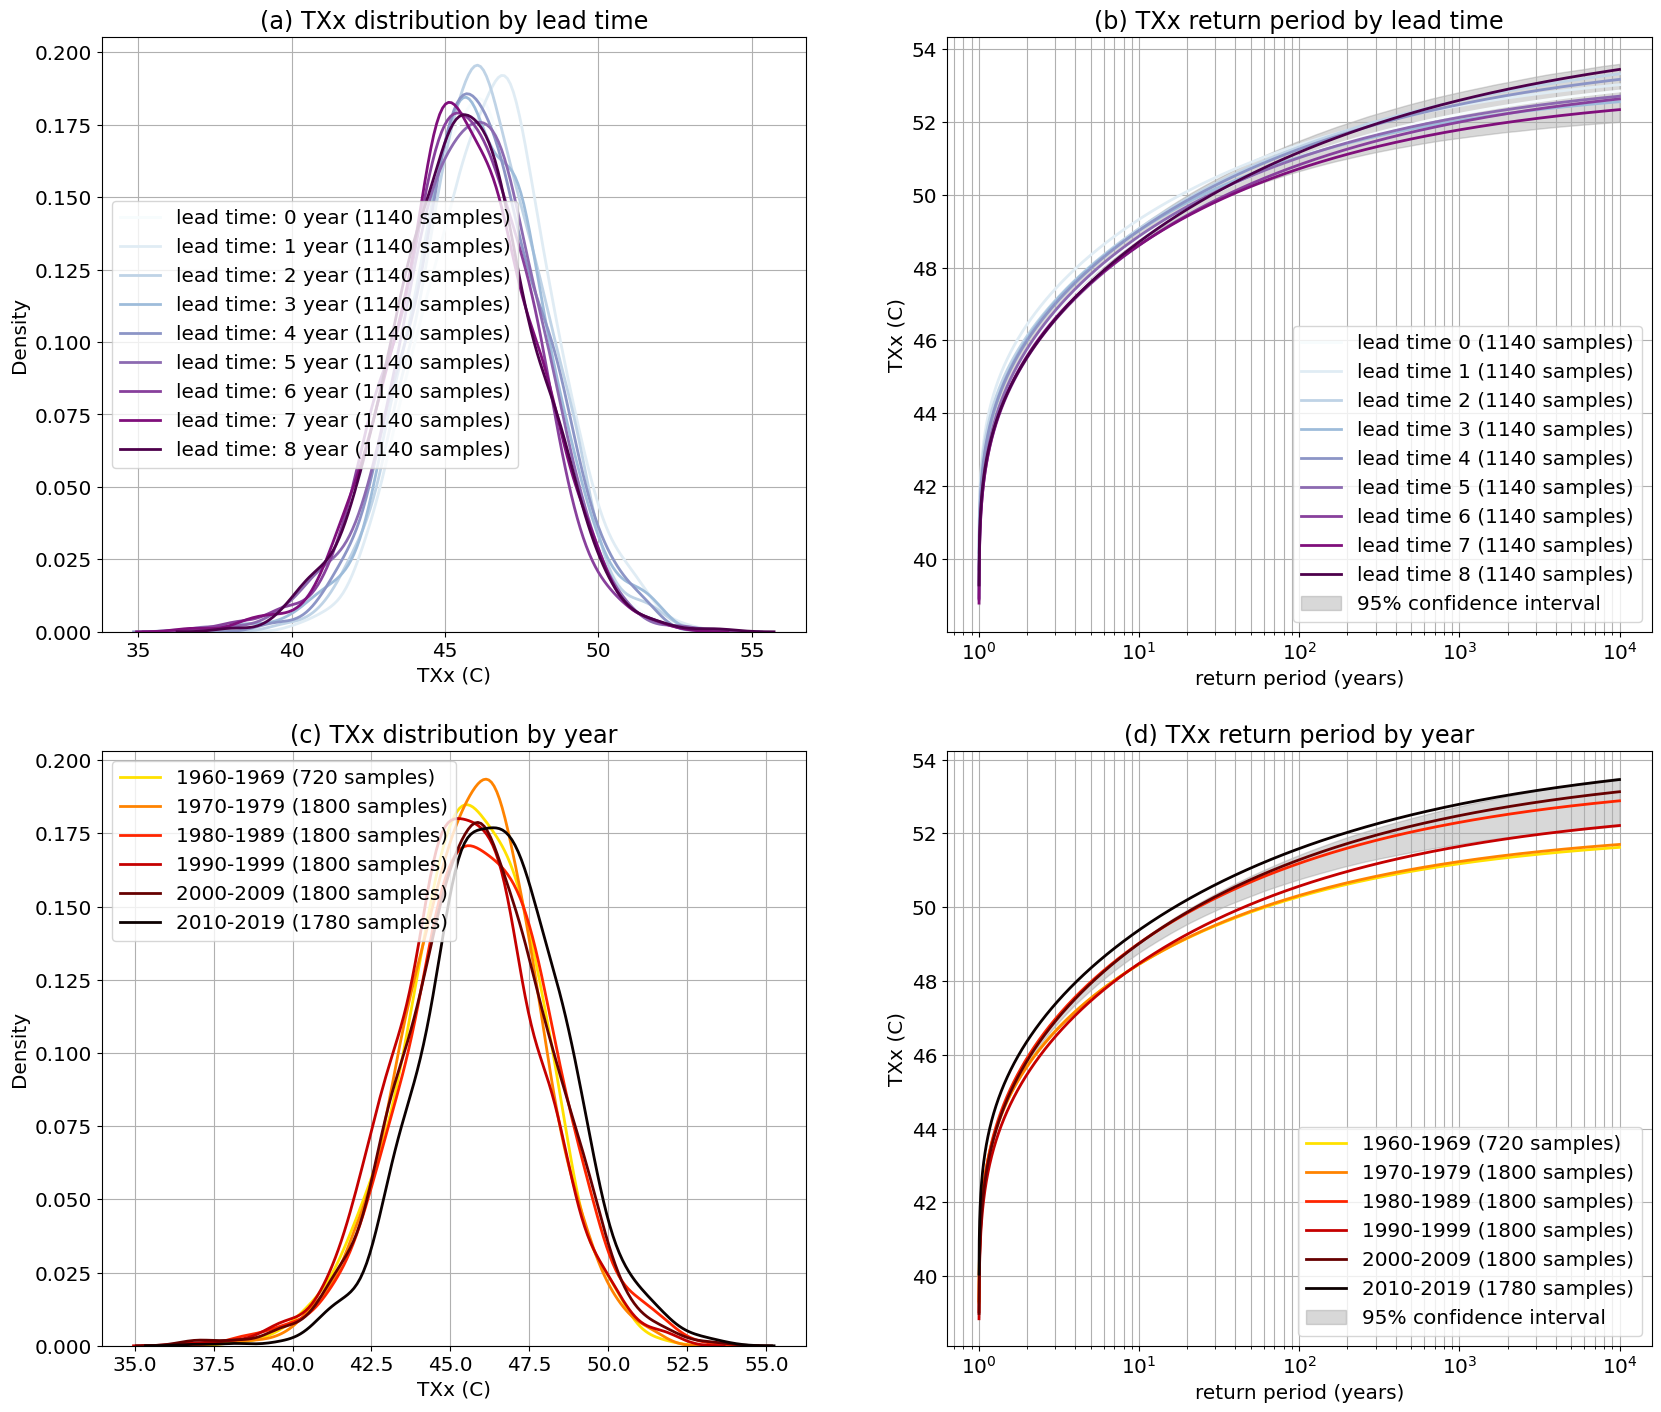

In [29]:
stability.create_plot(
    da_model,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


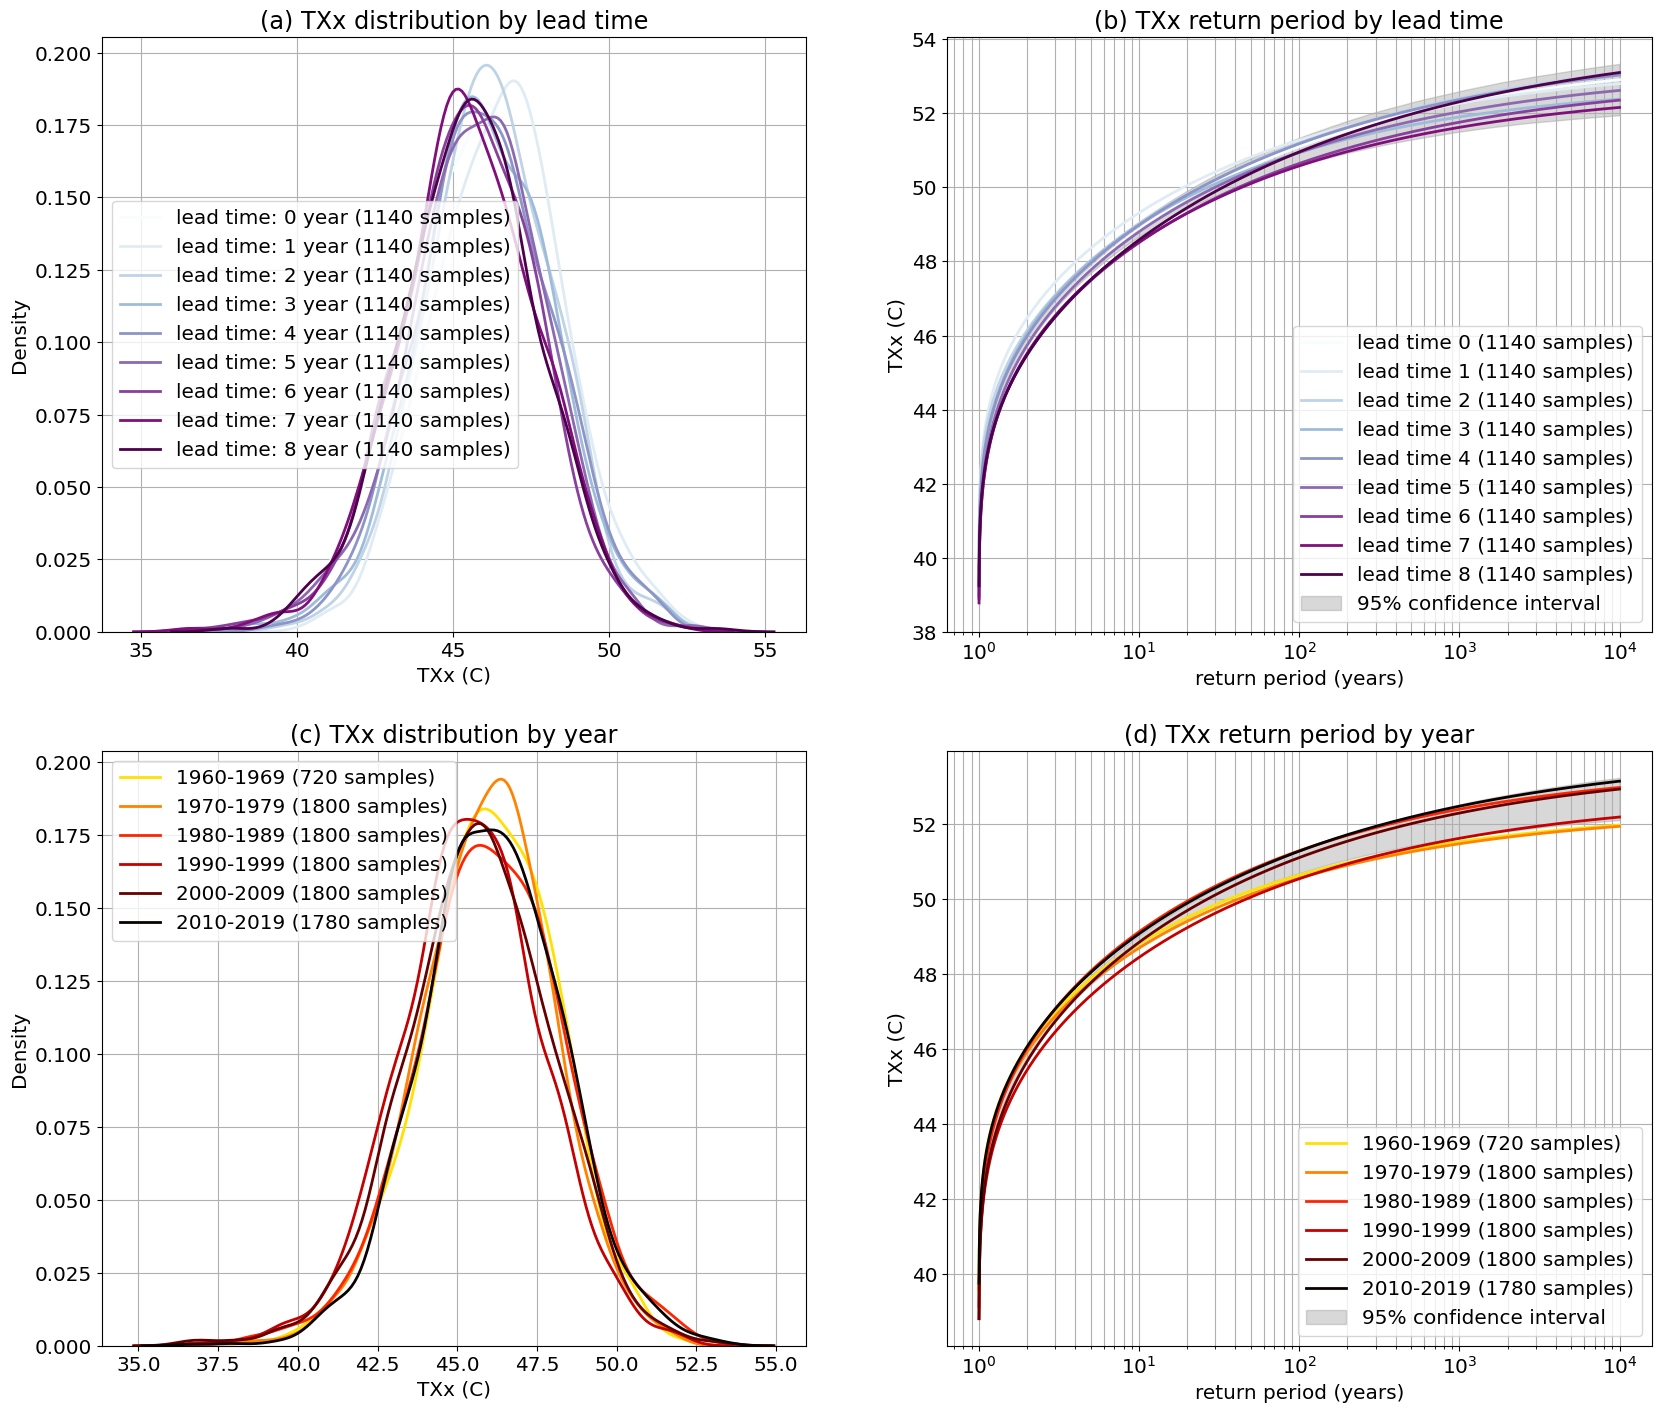

In [30]:
stability.create_plot(
    da_model_detrended,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

In [32]:
gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended = eva.fit_gev(da_model_detrended_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended:.2f}')
print(f'Location parameter: {gev_loc_model_detrended:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended:.2f}')

Shape parameter: 0.26
Location parameter: 45.05
Scale parameter: 2.26


### Mean correction

#### Additive

In [33]:
bias_mean_add = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [34]:
da_model_detrended_bc_mean_add = bias_correction.remove_bias(da_model_detrended, bias_mean_add, 'additive')

In [35]:
da_model_detrended_bc_mean_add = da_model_detrended_bc_mean_add.compute()

In [36]:
da_model_detrended_bc_mean_add_stacked = da_model_detrended_bc_mean_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [37]:
gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add = eva.fit_gev(da_model_detrended_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_add:.2f}')

Shape parameter: 0.26
Location parameter: 42.89
Scale parameter: 2.26


#### Multiplicative

In [38]:
bias_mean_mulc = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [39]:
da_model_detrended_bc_mean_mulc = bias_correction.remove_bias(da_model_detrended, bias_mean_mulc, 'additive')
da_model_detrended_bc_mean_mulc = da_model_detrended_bc_mean_mulc.compute()

In [40]:
da_model_detrended_bc_mean_mulc_stacked = da_model_detrended_bc_mean_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [41]:
gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc = eva.fit_gev(da_model_detrended_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_mulc:.2f}')

Shape parameter: 0.26
Location parameter: 44.00
Scale parameter: 2.26


### Quantile correction

In [42]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [43]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [44]:
da_model_detrended_q = nbutils.quantile(
    da_model_detrended_stacked,
    quantile_array,
    ['sample']
)

# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [45]:
da_model_detrended_q.values

array([42.22977976, 43.62117858, 44.46054973, 45.05564027, 45.61277615,
       46.15201219, 46.71967305, 47.34936841, 48.11759207, 49.36615407])

In [46]:
da_obs_detrended_q = nbutils.quantile(
    da_obs_detrended,
    quantile_array,
    ['time']
)

# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [47]:
da_obs_detrended_q.values

array([40.71422953, 41.9785898 , 42.59248404, 42.9557624 , 43.47237291,
       44.10058049, 44.65355916, 44.9697878 , 45.61747121, 46.71211385])

In [48]:
bias_quantile_add = da_model_detrended_q.values - da_obs_detrended_q.values

In [49]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

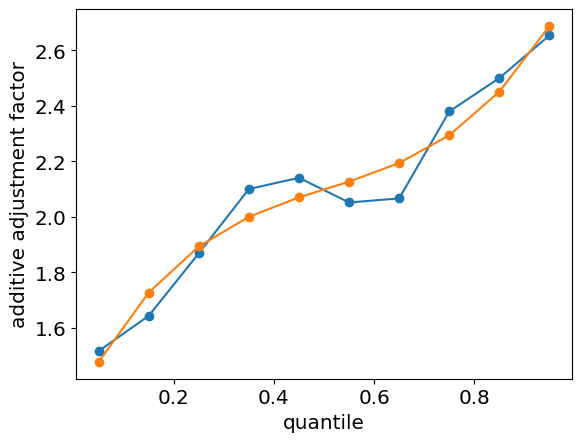

In [50]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [51]:
bias_quantile_mulc = da_model_detrended_q.values / da_obs_detrended_q.values

In [52]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

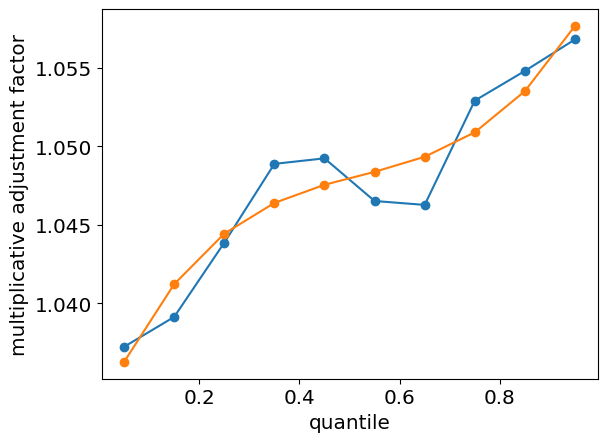

In [53]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [54]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [55]:
#af_add = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_add,
#)
af_add = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [56]:
da_model_detrended_bc_quantile_add = da_model_detrended_stacked - af_add

In [57]:
gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add = eva.fit_gev(da_model_detrended_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_add:.2f}')

Shape parameter: 0.25
Location parameter: 43.07
Scale parameter: 1.93


#### Multiplicative

In [58]:
#af_mulc = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_mulc,
#)
af_mulc = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [59]:
da_model_detrended_bc_quantile_mulc = da_model_detrended_stacked / af_mulc

In [60]:
gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc = eva.fit_gev(da_model_detrended_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_mulc:.2f}')

Shape parameter: 0.25
Location parameter: 43.07
Scale parameter: 1.92


## Comparison

In [61]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model_detrended,
        da_obs_detrended,
        da_bc_fcst=da_target,
    )

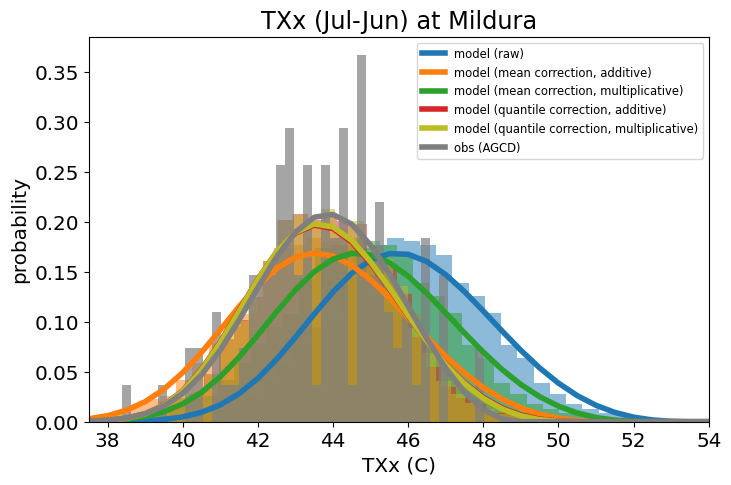

In [62]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(30, 65, 0.5)

da_model_detrended_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model_detrended = gev.pdf(gev_xvals, gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended)
plt.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_detrended_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_detrended_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_add,
    gev_loc_model_detrended_bc_mean_add,
    gev_scale_model_detrended_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_detrended_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_detrended_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_mulc,
    gev_loc_model_detrended_bc_mean_mulc,
    gev_scale_model_detrended_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_detrended_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_add,
    gev_loc_model_detrended_bc_quantile_add,
    gev_scale_model_detrended_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_detrended_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_mulc,
    gev_loc_model_detrended_bc_quantile_mulc,
    gev_scale_model_detrended_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs_detrended.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs_detrended = gev.pdf(gev_xvals, gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended)
plt.plot(gev_xvals, gev_pdf_obs_detrended, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at Mildura')
plt.xlim(37.5, 54)
plt.legend(fontsize='small')
plt.savefig('txx_mildura_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [63]:
similarity_ds = similarity.similarity_tests(da_model_detrended, da_obs_detrended)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.43041626
KS p-value: 2.2935203e-19
AD score: 67.06082
AD p-value: 0.001


### Additive - mean correction

KS score: 0.10108075
KS p-value: 0.18928066
AD score: 0.1530523
AD p-value: 0.25


INFO:root:mean: Obs = 43.77656936645507, Model 95% CI =45.463198501585865 to 46.29557871316065
INFO:root:standard deviation: Obs = 1.8281028275622568, Model 95% CI =1.87447697495179 to 2.53085080766966
INFO:root:skew: Obs = -0.14920976160138083, Model 95% CI =-0.7465143135519617 to 0.3927410126225559
INFO:root:kurtosis: Obs = -0.057444671608331, Model 95% CI =-0.6420152242144292 to 1.7023288652237671
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.32409837)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.16784518841744175 to 0.4463050070807757
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(43.16694504)
Coordinates:
    lat      float64 8B -34.0
    lon      float64

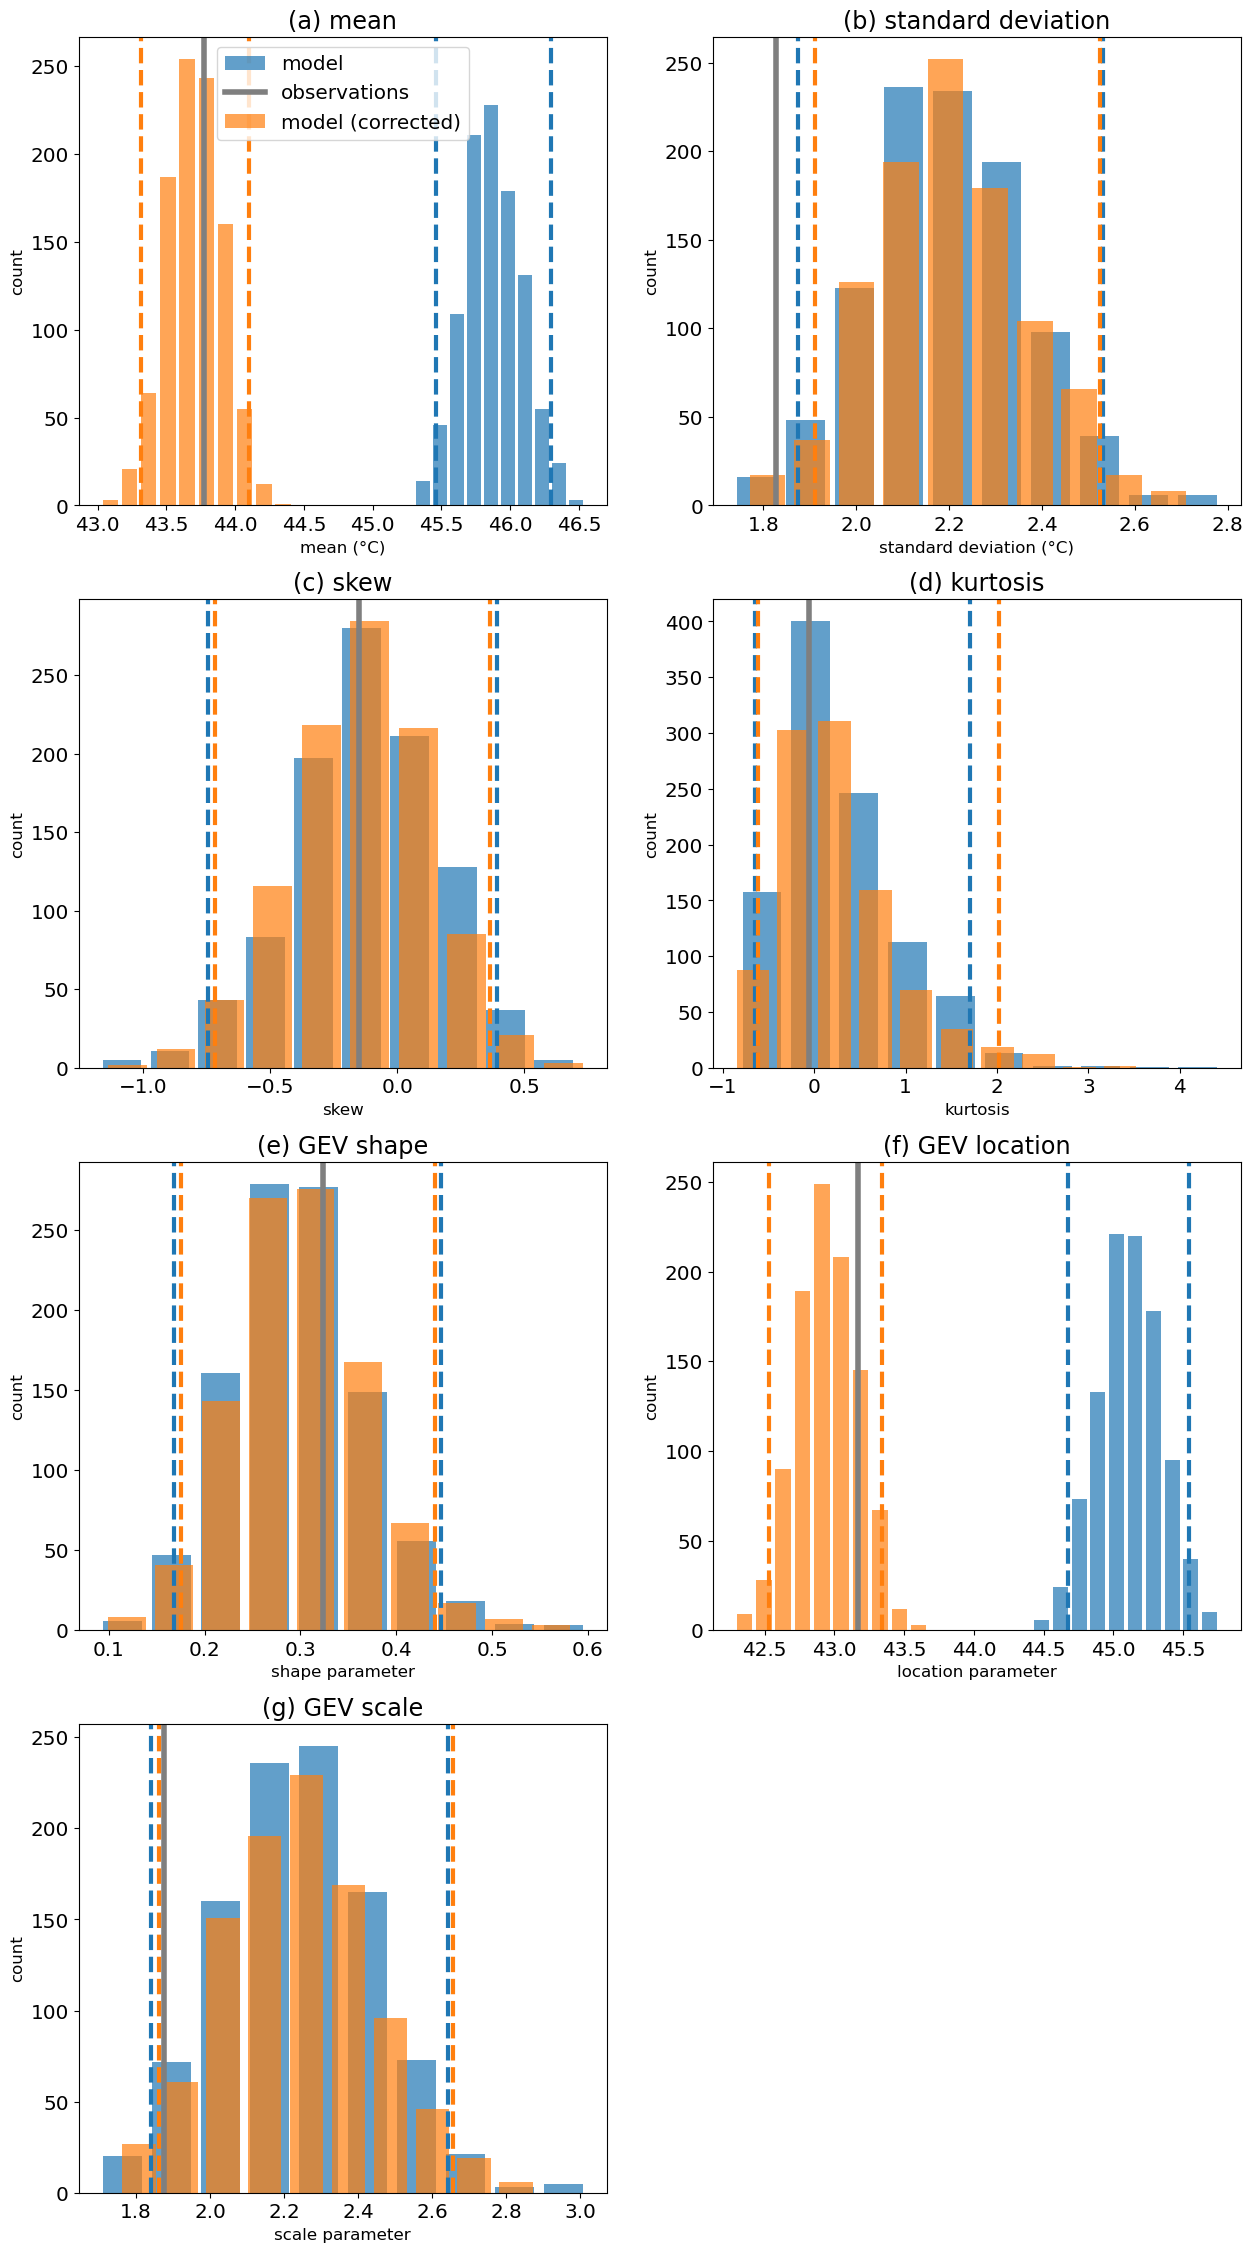

In [64]:
fidelity_tests(da_model_detrended_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.29971623
KS p-value: 2.0322322e-09
AD score: 24.787285
AD p-value: 0.001


INFO:root:mean: Obs = 43.77656936645507, Model 95% CI =45.44155662308171 to 46.29274857208344
INFO:root:standard deviation: Obs = 1.8281028275622568, Model 95% CI =1.913466392131848 to 2.5098291844372604
INFO:root:skew: Obs = -0.14920976160138083, Model 95% CI =-0.7355548188963671 to 0.35017887793940955
INFO:root:kurtosis: Obs = -0.057444671608331, Model 95% CI =-0.5769307820181867 to 1.8802415822347474
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.32409837)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.17546279128156503 to 0.4398624837770174
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(43.16694504)
Coordinates:
    lat      float64 8B -34.0
    lon      floa

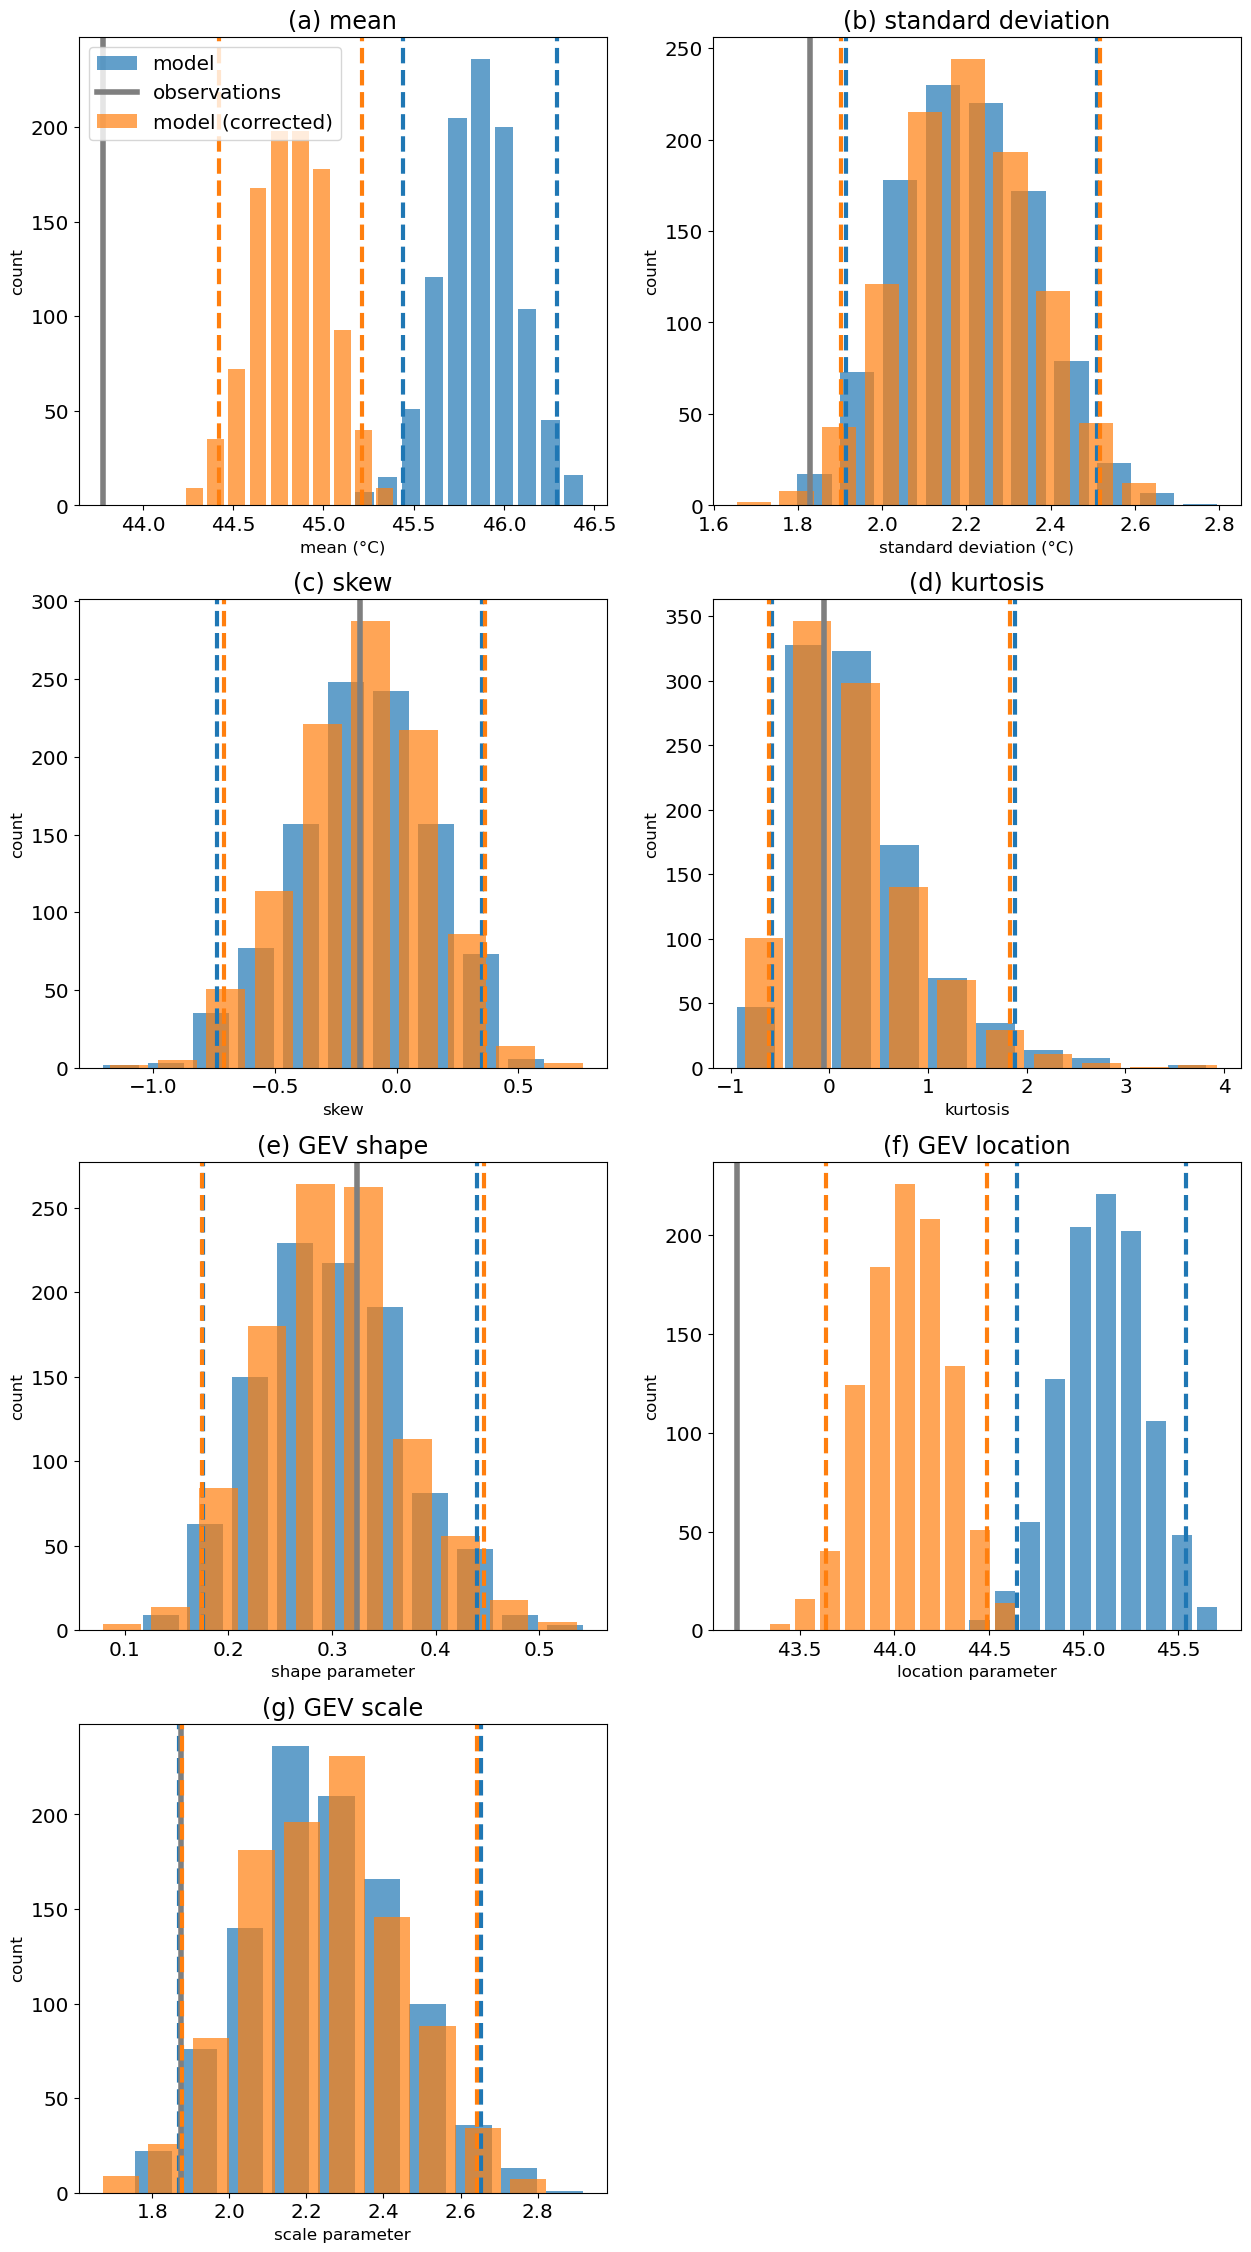

In [65]:
fidelity_tests(da_model_detrended_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.088020325
KS p-value: 0.33118606
AD score: 0.07982615
AD p-value: 0.25


INFO:root:mean: Obs = 43.77656936645507, Model 95% CI =45.46825225361086 to 46.290466695089194
INFO:root:standard deviation: Obs = 1.8281028275622568, Model 95% CI =1.8988955866632575 to 2.5234170500255013
INFO:root:skew: Obs = -0.14920976160138083, Model 95% CI =-0.7171003949818009 to 0.38160150837551393
INFO:root:kurtosis: Obs = -0.057444671608331, Model 95% CI =-0.6063324406937932 to 1.8907873156471375
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.32409837)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.1730624127491507 to 0.44040037397803883
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(43.16694504)
Coordinates:
    lat      float64 8B -34.0
    lon      fl

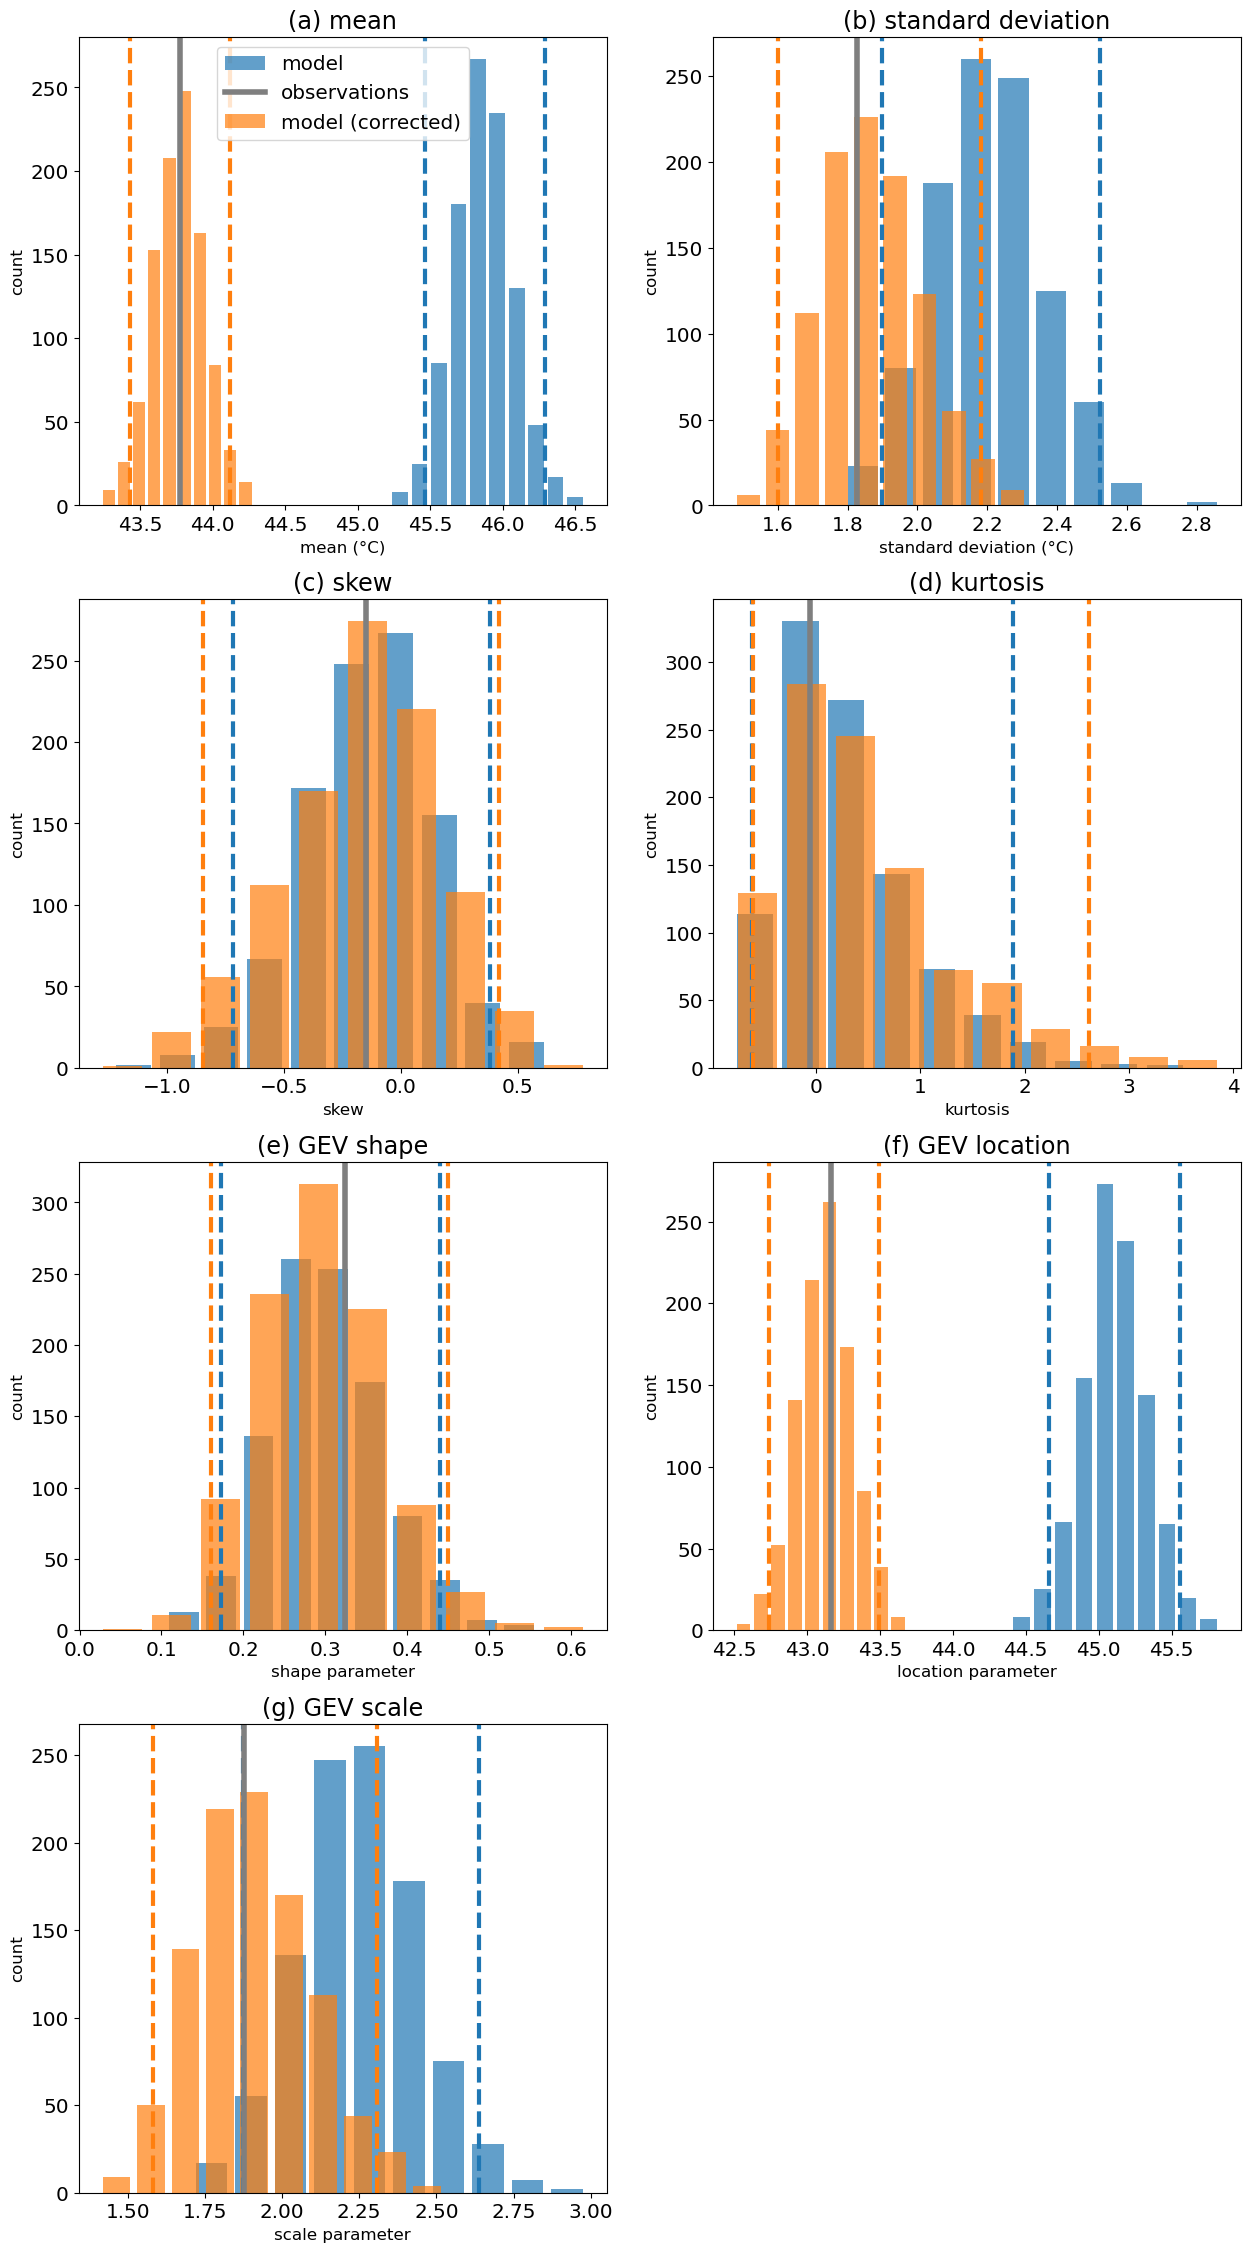

In [66]:
fidelity_tests(da_model_detrended_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.08772793
KS p-value: 0.33503735
AD score: 0.0673484
AD p-value: 0.25


INFO:root:mean: Obs = 43.77656936645507, Model 95% CI =45.46858704614617 to 46.279298260387925
INFO:root:standard deviation: Obs = 1.8281028275622568, Model 95% CI =1.8933612876727337 to 2.5222691189331496
INFO:root:skew: Obs = -0.14920976160138083, Model 95% CI =-0.7249660224309737 to 0.381056853144601
INFO:root:kurtosis: Obs = -0.057444671608331, Model 95% CI =-0.5784790884361308 to 1.8864708453339727
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.32409837)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.17478195463548166 to 0.4456863222399847
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(43.16694504)
Coordinates:
    lat      float64 8B -34.0
    lon      floa

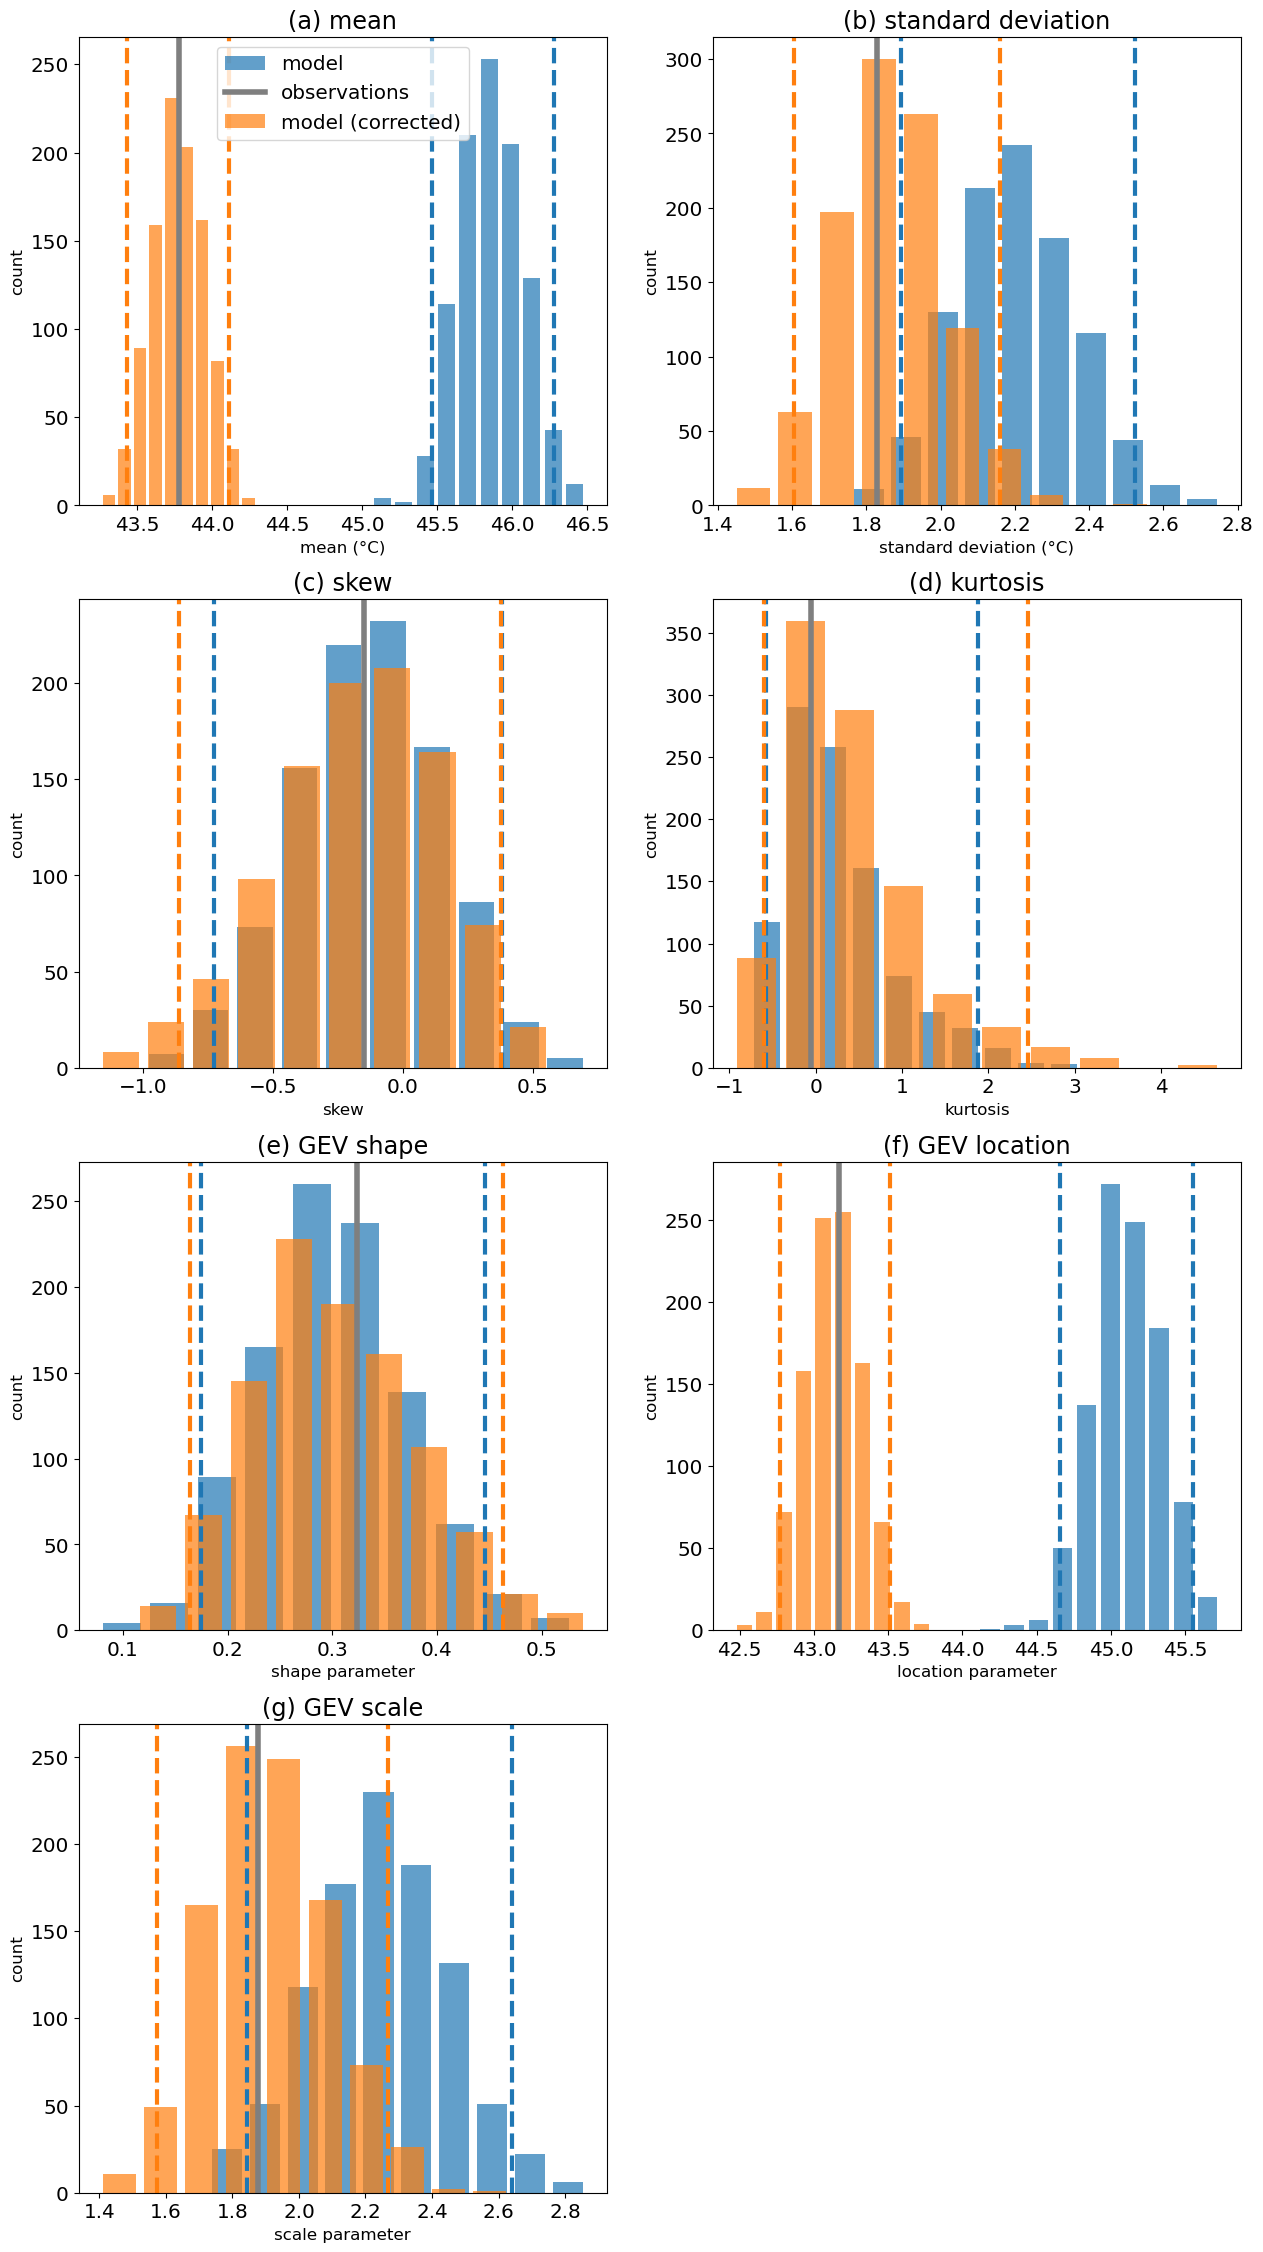

In [67]:
fidelity_tests(da_model_detrended_bc_quantile_mulc.unstack())